# Introduction
This file is a Jupyter notebook that contains the code for the classification model.
The parts of the notebook are:
1. The first part of the notebook imports the necessary libraries and datasets and preprocessing the image dataset (CIFAR-10).
2. The second part of the notebook defines the model architecture and training parameters.

# 1. Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 2. Import Dataset
- The CIFAR-10 dataset is a collection of 60,000 32x32 color images in 10 classes, with 5,000 images in each class. The dataset is divided into 50,000 training images and 10,000 test images.
- This is the Dataset we will be using for our image classification model.

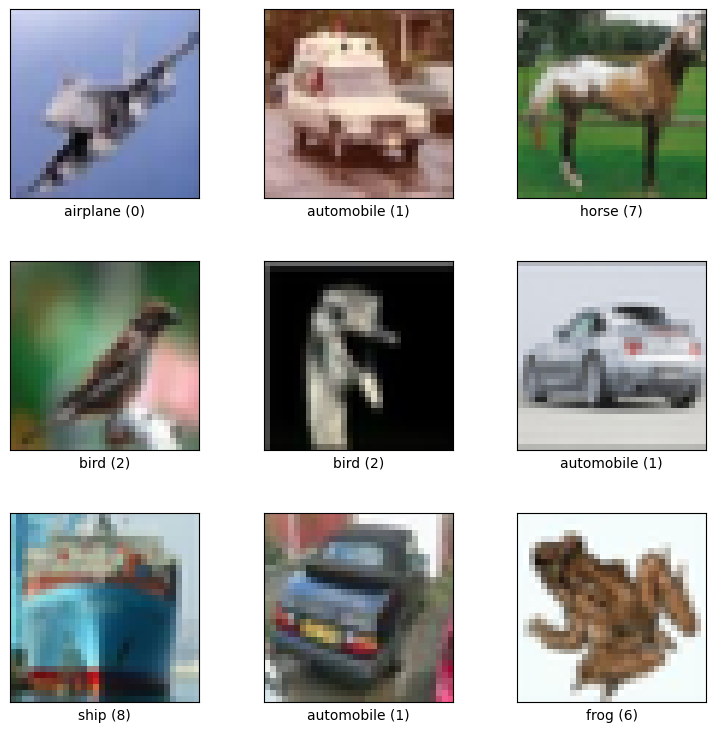

In [3]:
(train_data, val_data, test_data), data_info = tfds.load("cifar10", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            as_supervised=True, with_info=True, shuffle_files=True)
fig = tfds.show_examples(train_data, data_info)

In [4]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [5]:
y_train = []
for img, label in train_data:
    y_train.append(int(label))

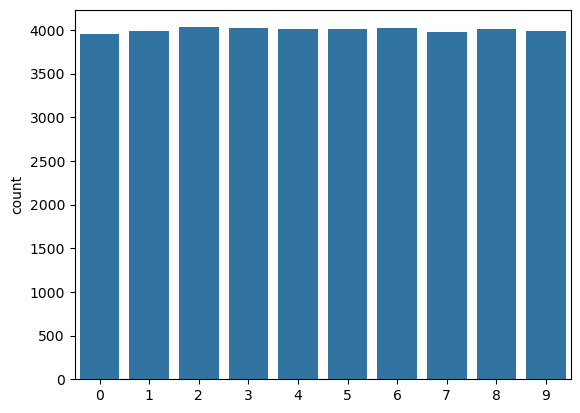

In [6]:
sns.countplot(x=y_train)
plt.show()

`Classes are mostly well distributed`

In [7]:
data_augmentation = keras.Sequential([
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1.0 / 255.0) 
])


def augment(image, label):
    return data_augmentation(image), label


def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_data = train_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_data = val_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# 3. Building the CNN Model
The Custom CNN model will feature 4 main blocks, each containing the following layers:
1. Convolutional Layer (Conv2d)
2. Batch Normalization Layer (BatchNorm2d)
3. Activation Layer (ReLU)
4. Pooling Layer (MaxPool2d)

Then it will pass by a flattening layer and finally a fully connected layer where the number of outputs will be equal to the number of classes.


In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [10]:
# Use a pretrained base model
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Add custom classifier on top
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

# 3.1. Compiling and Callbacks
In this section, we will be compiling the model and defining the callbacks.
Important callbacks:
1. Early Stopping
2. Reduce Learning Rate
3. Model Checkpoint

And finally for the optimizer and loss function:
1. Adam Optimizer
2. Cross Entropy Loss

In [11]:
# Complile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# 3.4. Training the 1st iteration of the model
In this section, we will train the first iteration of the model.
- All layers frozen (un-trainable).
- Model as is.
- 10 epochs.

In [13]:
epochs = 10

In [70]:
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.4934 - loss: 1.4544

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 574s 455ms/step - accuracy: 0.5659 - loss: 1.2350 - val_accuracy: 0.7262 - val_loss: 0.7980 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6221 - loss: 1.0709

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 576s 460ms/step - accuracy: 0.6265 - loss: 1.0601 - val_accuracy: 0.7448 - val_loss: 0.7332 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.6395 - loss: 1.0394

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 571s 456ms/step - accuracy: 0.6385 - loss: 1.0370 - val_accuracy: 0.7488 - val_loss: 0.7259 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 580s 464ms/step - accuracy: 0.6384 - loss: 1.0304 - val_accuracy: 0.7506 - val_loss: 0.7333 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 568s 454ms/step - accuracy: 0.6391 - loss: 1.0258 - val_accuracy: 0.7409 - val_loss: 0.7424 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6549 - loss: 0.9842

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 565s 452ms/step - accuracy: 0.6578 - loss: 0.9746 - val_accuracy: 0.7584 - val_loss: 0.7048 - learning_rate: 2.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 567s 453ms/step - accuracy: 0.6583 - loss: 0.9677 - val_accuracy: 0.7571 - val_loss: 0.7071 - learning_rate: 2.0000e-04
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6600 - loss: 0.9626

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 553s 442ms/step - accuracy: 0.6610 - loss: 0.9605 - val_accuracy: 0.7576 - val_loss: 0.7019 - learning_rate: 2.0000e-04
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.6626 - loss: 0.9535

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 551s 440ms/step - accuracy: 0.6625 - loss: 0.9549 - val_accuracy: 0.7606 - val_loss: 0.6903 - learning_rate: 2.0000e-04
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 555s 443ms/step - accuracy: 0.6610 - loss: 0.9548 - val_accuracy: 0.7584 - val_loss: 0.7000 - learning_rate: 2.0000e-04


In [74]:
# save the model
model.save('cifar10_model.keras')

### 3.4.1. Evaluating the first iteration of the model
In this section, we will evaluate only the first iteration of the model:
1. 10 epochs.
2. All the layers are frozen (un-trainable). 

Results of training:
- 1250/1250 ━━━━━━━━━━━━━━━━━━━━ 555s 443ms/step - accuracy: 0.6610 - loss: 0.9548 - val_accuracy: 0.7584 - val_loss: 0.7000 - learning_rate: 2.0000e-04

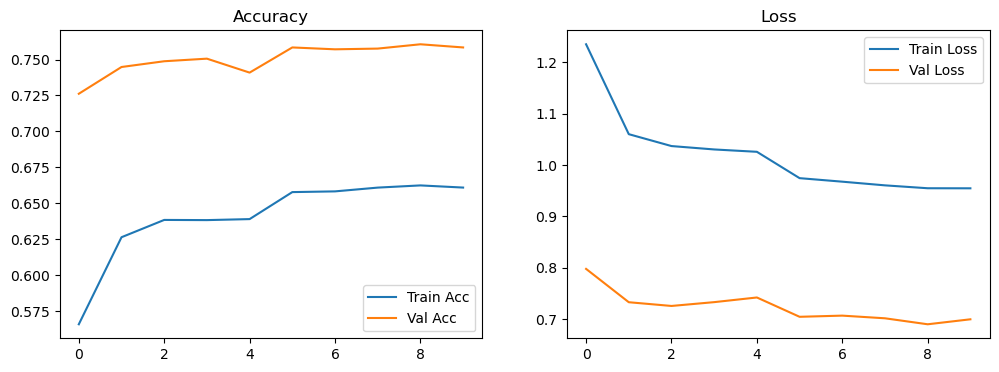

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Load the model
model = keras.models.load_model('cifar10_model.keras')

In [75]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 348ms/step - accuracy: 0.7556 - loss: 0.6960
Test accuracy: 0.7555999755859375
Test loss: 0.6960166096687317


- The first iteration of the model achieved a test accuracy of 0.75 ~ 75% and a test loss of 0.6960

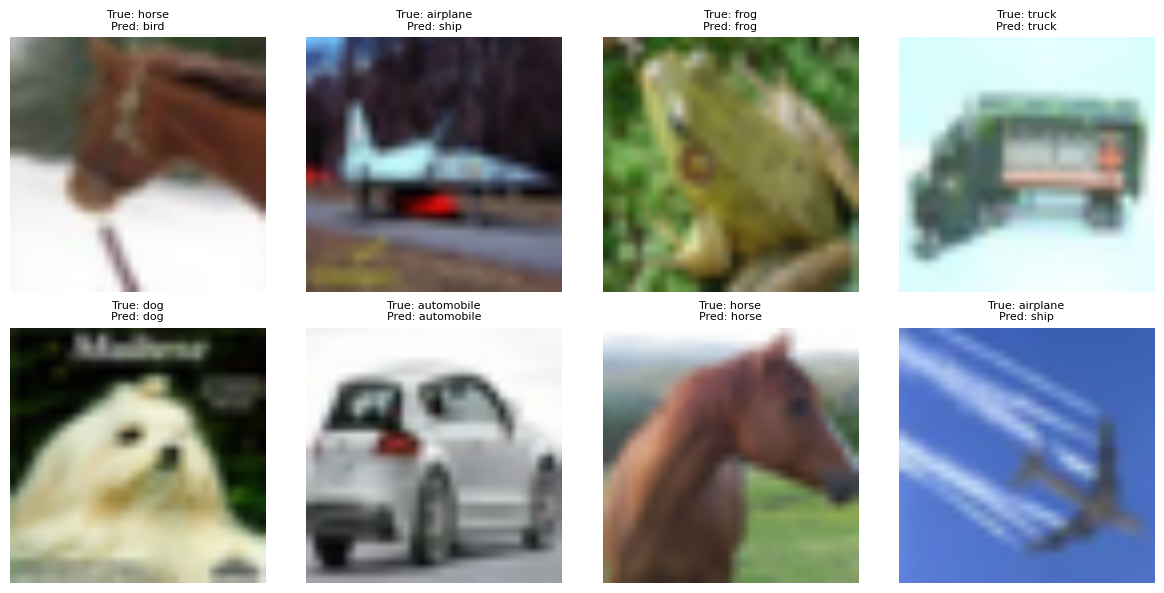

In [76]:
def plot_predictions(images, true_labels, pred_labels, class_names, n=8):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, 4, i + 1)
        img = images[i].numpy() * 255.0
        img = np.clip(img, 0, 255).astype("uint8")
        plt.imshow(img)
        true_cls = class_names[true_labels[i]]
        pred_cls = class_names[pred_labels[i]]
        plt.title(f"True: {true_cls}\nPred: {pred_cls}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get one batch from test set
sample_images, sample_labels = next(iter(test_data))
sample_preds = model.predict(sample_images, verbose=0)
sample_pred_labels = np.argmax(sample_preds, axis=1)

plot_predictions(sample_images, sample_labels, sample_pred_labels, classes)

## 3.5. Training the 2nd iteration of the model
In this section, we will train the second iteration of the model.
- 50 Layers unfrozen (trainable).
- epochs 20.

In [12]:
# Unfreezing the last 50 layers of the models
base_model.trainable = True
fine_tune = 50

# Freeze all the layers before the `fine_tune` layer
for layer in base_model.layers[:-fine_tune]:
    layer.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,855,104 (7.08 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [14]:
print(f"Trainable Layers: {len(model.trainable_variables)}")

Trainable Layers: 53


In [16]:
# Training the Model

epochs = 20
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.4054 - loss: 1.5698

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 817s 646ms/step - accuracy: 0.4800 - loss: 1.3813 - val_accuracy: 0.1008 - val_loss: 31.3255 - learning_rate: 0.0100
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6102 - loss: 1.0949

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 827s 661ms/step - accuracy: 0.6242 - loss: 1.0585 - val_accuracy: 0.1720 - val_loss: 22.0697 - learning_rate: 0.0100
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.6554 - loss: 0.9820

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 827s 661ms/step - accuracy: 0.6673 - loss: 0.9451 - val_accuracy: 0.2980 - val_loss: 9.5714 - learning_rate: 0.0100
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6914 - loss: 0.8887

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 832s 665ms/step - accuracy: 0.6963 - loss: 0.8718 - val_accuracy: 0.4032 - val_loss: 3.9764 - learning_rate: 0.0100
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.7119 - loss: 0.8348

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 846s 676ms/step - accuracy: 0.7155 - loss: 0.8210 - val_accuracy: 0.5018 - val_loss: 2.8411 - learning_rate: 0.0100
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.7288 - loss: 0.7813

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 849s 678ms/step - accuracy: 0.7315 - loss: 0.7768 - val_accuracy: 0.5247 - val_loss: 2.3737 - learning_rate: 0.0100
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7352 - loss: 0.7545

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 812s 649ms/step - accuracy: 0.7423 - loss: 0.7405 - val_accuracy: 0.6249 - val_loss: 1.7353 - learning_rate: 0.0100
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7448 - loss: 0.7320

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 815s 651ms/step - accuracy: 0.7477 - loss: 0.7267 - val_accuracy: 0.6227 - val_loss: 1.5415 - learning_rate: 0.0100
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 834s 666ms/step - accuracy: 0.7597 - loss: 0.6856 - val_accuracy: 0.6467 - val_loss: 1.6207 - learning_rate: 0.0100
Epoch 10/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7689 - loss: 0.6737

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 824s 659ms/step - accuracy: 0.7720 - loss: 0.6652 - val_accuracy: 0.6960 - val_loss: 1.1218 - learning_rate: 0.0100
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 833s 666ms/step - accuracy: 0.7785 - loss: 0.6388 - val_accuracy: 0.6062 - val_loss: 1.9599 - learning_rate: 0.0100
Epoch 12/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 831s 664ms/step - accuracy: 0.7846 - loss: 0.6204 - val_accuracy: 0.6887 - val_loss: 1.3465 - learning_rate: 0.0100
Epoch 13/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8099 - loss: 0.5534

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 824s 658ms/step - accuracy: 0.8184 - loss: 0.5284 - val_accuracy: 0.8169 - val_loss: 0.5607 - learning_rate: 0.0020
Epoch 14/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.8223 - loss: 0.5111

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 805s 643ms/step - accuracy: 0.8252 - loss: 0.5018 - val_accuracy: 0.8349 - val_loss: 0.4856 - learning_rate: 0.0020
Epoch 15/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8296 - loss: 0.4935

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 765s 611ms/step - accuracy: 0.8315 - loss: 0.4842 - val_accuracy: 0.8373 - val_loss: 0.4717 - learning_rate: 0.0020
Epoch 16/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 760s 607ms/step - accuracy: 0.8330 - loss: 0.4818 - val_accuracy: 0.8359 - val_loss: 0.4804 - learning_rate: 0.0020
Epoch 17/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8321 - loss: 0.4807

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 814s 651ms/step - accuracy: 0.8360 - loss: 0.4705 - val_accuracy: 0.8436 - val_loss: 0.4675 - learning_rate: 0.0020
Epoch 18/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8357 - loss: 0.4755

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 779s 622ms/step - accuracy: 0.8376 - loss: 0.4689 - val_accuracy: 0.8406 - val_loss: 0.4674 - learning_rate: 0.0020
Epoch 19/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8366 - loss: 0.4626

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 752s 601ms/step - accuracy: 0.8417 - loss: 0.4514 - val_accuracy: 0.8419 - val_loss: 0.4562 - learning_rate: 0.0020
Epoch 20/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 757s 605ms/step - accuracy: 0.8451 - loss: 0.4446 - val_accuracy: 0.8404 - val_loss: 0.4684 - learning_rate: 0.0020


In [17]:
# Save the model
model.save('cifar10_model_final_improved.keras')

## 3.6. Evaluating the 2nd iteration of the model
In this section, we will evaluate only the second iteration of the model:
- We will load the saved model then begin evaluating it.

In [14]:
# Load saved model
model = keras.models.load_model('cifar10_model_final_improved.keras')

c:\Users\basel\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 55 variables whereas the saved optimizer has 108 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 365ms/step - accuracy: 0.8427 - loss: 0.4596
Test accuracy: 0.8427000045776367
Test loss: 0.45964229106903076


In [19]:
# Accuracy and Predictions
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro')}")
print(f"Full classification report: {classification_report(y_true, y_pred)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

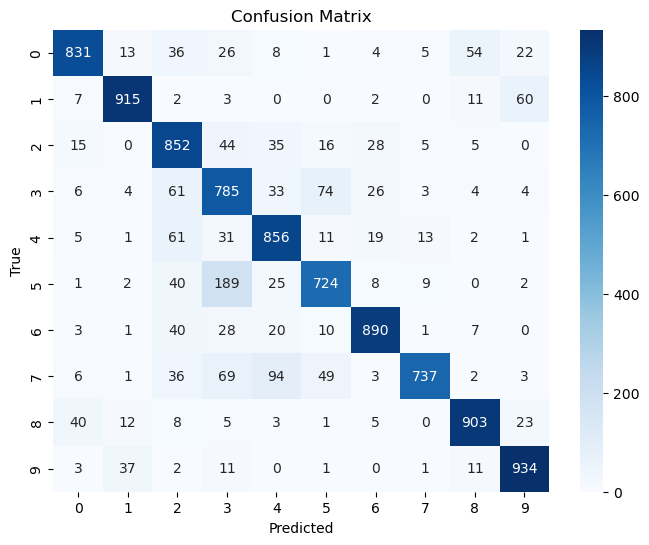

In [23]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()